In [21]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Ensure async compatibility for Jupyter environments
try:
    import nest_asyncio
    # Only apply if running in Jupyter/IPython environment
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            nest_asyncio.apply()
    except ImportError:
        pass  # Not in Jupyter, no need for nest_asyncio
except ImportError:
    pass  # nest_asyncio not available, proceed without it

# Research Sub Agent

In [23]:
"""
State Definitions and Pydantic Schemas for Research Agent

This module defines the state objects and structured schemas used for
the research agent workflow, including researcher state management and output schemas.
"""

import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class ResearcherState(TypedDict):
    """
    State for the research agent containing message history and research metadata.
    
    This state tracks the researcher's conversation, iteration count for limiting
    tool calls, the research topic being investigated, compressed findings,
    and raw research notes for detailed analysis.
    """
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    # used to prevent too many tool calls, in this subagent
    tool_call_iterations: int
    research_topic: str
    # final result given back to the main agent
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    
class ResearcherOutputState(TypedDict):
    """
    Output state for the research agent containing final research results.
    
    This represents the final output of the research process with compressed
    research findings and all raw notes from the research process.
    """
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decisions during scoping phase."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for research brief generation."""
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )



In [ ]:
"""Research Utilities and Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""

from pathlib import Path
from datetime import datetime
from typing_extensions import Annotated, List, Literal

from langchain.chat_models import init_chat_model 
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from tavily import TavilyClient

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

tavily_client = TavilyClient()

def tavily_search_multiple(
    search_queries: List[str], 
    max_results: int = 3, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> List[dict]:
    """Perform search using Tavily API for multiple queries.

    Args:
        search_queries: List of search queries to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        List of search result dictionaries
    """
    
    # Execute searches sequentially. Note: yon can use AsyncTavilyClient to parallelize this step.
    search_docs = []
    for query in search_queries:
        result = tavily_client.search(
            query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic
        )
        search_docs.append(result)

    return search_docs

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    summary: str = Field(description="Concise summary of the webpage content")
    key_excerpts: str = Field(description="Important quotes and excerpts from the content")

def summarize_webpage_content(webpage_content: str) -> str:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Formatted summary with key excerpts
    """
    
    try:
      summarization_model = init_chat_model(model="openai:gpt-4.1-mini")
      structured_model = summarization_model.with_structured_output(Summary)

      SUMMARIZE_WEBPAGE_PROMPT = """
      You are tasked with summarizing the raw content of a webpage retrieved from a web search. Your goal is to create a summary that preserves the most important information from the original web page. This summary will be used by a downstream research agent, so it's crucial to maintain the key details without losing essential information.

      Here is the raw content of the webpage:

      <webpage_content>
      {webpage_content}
      </webpage_content>

      Please follow these guidelines to create your summary:

      1. Identify and preserve the main topic or purpose of the webpage.
      2. Retain key facts, statistics, and data points that are central to the content's message.
      3. Keep important quotes from credible sources or experts.
      4. Maintain the chronological order of events if the content is time-sensitive or historical.
      5. Preserve any lists or step-by-step instructions if present.
      6. Include relevant dates, names, and locations that are crucial to understanding the content.
      7. Summarize lengthy explanations while keeping the core message intact.

      When handling different types of content:

      - For news articles: Focus on the who, what, when, where, why, and how.
      - For scientific content: Preserve methodology, results, and conclusions.
      - For opinion pieces: Maintain the main arguments and supporting points.
      - For product pages: Keep key features, specifications, and unique selling points.

      Your summary should be significantly shorter than the original content but comprehensive enough to stand alone as a source of information. Aim for about 25-30 percent of the original length, unless the content is already concise.

      Present your summary in the following format:

      ```
      {{
         "summary": "Your summary here, structured with appropriate paragraphs or bullet points as needed",
         "key_excerpts": "First important quote or excerpt, Second important quote or excerpt, Third important quote or excerpt, ...Add more excerpts as needed, up to a maximum of 5"
      }}
      ```

      Here are two examples of good summaries:

      Example 1 (for a news article):
      ```json
      {{
         "summary": "On July 15, 2023, NASA successfully launched the Artemis II mission from Kennedy Space Center. This marks the first crewed mission to the Moon since Apollo 17 in 1972. The four-person crew, led by Commander Jane Smith, will orbit the Moon for 10 days before returning to Earth. This mission is a crucial step in NASA's plans to establish a permanent human presence on the Moon by 2030.",
         "key_excerpts": "Artemis II represents a new era in space exploration, said NASA Administrator John Doe. The mission will test critical systems for future long-duration stays on the Moon, explained Lead Engineer Sarah Johnson. We're not just going back to the Moon, we're going forward to the Moon, Commander Jane Smith stated during the pre-launch press conference."
      }}
      ```

      Example 2 (for a scientific article):
      ```json
      {{
         "summary": "A new study published in Nature Climate Change reveals that global sea levels are rising faster than previously thought. Researchers analyzed satellite data from 1993 to 2022 and found that the rate of sea-level rise has accelerated by 0.08 mm/year² over the past three decades. This acceleration is primarily attributed to melting ice sheets in Greenland and Antarctica. The study projects that if current trends continue, global sea levels could rise by up to 2 meters by 2100, posing significant risks to coastal communities worldwide.",
         "key_excerpts": "Our findings indicate a clear acceleration in sea-level rise, which has significant implications for coastal planning and adaptation strategies, lead author Dr. Emily Brown stated. The rate of ice sheet melt in Greenland and Antarctica has tripled since the 1990s, the study reports. Without immediate and substantial reductions in greenhouse gas emissions, we are looking at potentially catastrophic sea-level rise by the end of this century, warned co-author Professor Michael Green."  
      }}
      ```

      Remember, your goal is to create a summary that can be easily understood and utilized by a downstream research agent while preserving the most critical information from the original webpage.

      Today's date is {date}.
      """
      
      response = structured_model.invoke([
        HumanMessage(content=SUMMARIZE_WEBPAGE_PROMPT.format(
          webpage_content=webpage_content,
          date=get_today_str()
        ))
      ])

      formatted_summary = (
        f"<summary>\n{response.summary}\n</summary>",
        f"<key_excerpts>\n{response.key_excerpts}\n</key_excerpts>"
      )

      return formatted_summary

    except Exception as e:
      print(f"Failed to summarize webpage: {str(e)}")
      return webpage_content[:1000] if len(webpage_content) > 100 else webpage_content
    
"""
search_results = [
  {
    "query": "Who is Leo Messi?",
    "answer": "Lionel Messi, born in 1987, is an Argentine footballer widely regarded as one of the greatest players of his generation. He spent the majority of his career playing for FC Barcelona, where he won numerous domestic league titles and UEFA Champions League titles. Messi is known for his exceptional dribbling skills, vision, and goal-scoring ability. He has won multiple FIFA Ballon d'Or awards, numerous La Liga titles with Barcelona, and holds the record for most goals scored in a calendar year. In 2014, he led Argentina to the World Cup final, and in 2015, he helped Barcelona capture another treble. Despite turning 36 in June, Messi remains highly influential in the sport.",
    "images": [],
    "results": [
      {
        "title": "Lionel Messi Facts | Britannica",
        "url": "https://www.britannica.com/facts/Lionel-Messi",
        "content": "Lionel Messi, an Argentine footballer, is widely regarded as one of the greatest football players of his generation. Born in 1987, Messi spent the majority of his career playing for Barcelona, where he won numerous domestic league titles and UEFA Champions League titles. Messi is known for his exceptional dribbling skills, vision, and goal",
        "score": 0.81025416,
        "raw_content": null,
        "favicon": "https://britannica.com/favicon.png"
      }
    ],
    "auto_parameters": {
      "topic": "general",
      "search_depth": "basic"
    },
    "response_time": "1.67",
    "request_id": "123e4567-e89b-12d3-a456-426614174111"
  },
  ....
]
"""
def deduplicate_search_results(search_results: List[dict]) -> dict:
    """Deduplicate search results by URL to avoid processing duplicate content.
    
    Args:
        search_results: List of search result dictionaries
        
    Returns:
        Dictionary mapping URLs to unique results
    """
    
    unique_results = {}
    
    for response in search_results:
      for result in response['results']:
        url = result['url']
        if url not in unique_results:
          unique_results[url] = result
    
    return unique_results
  

def process_search_results(unique_results: dict) -> dict:
    """Process search results by summarizing content where available.
    
    Args:
        unique_results: Dictionary of unique search results
        
    Returns:
        Dictionary of processed results with summaries
    """

    summarized_results = {}
    
    for url, result in unique_results.items():
      # use existing content if no raw content for summarization
      if not result.get('raw_content'):
        content = result['content']
      else:
        content = summarize_webpage_content(result['raw_content'])
      
      summarized_results[url] = {
        'title': result['title'],
        'content': content
      }
    
    return summarized_results

def format_search_output(summarized_results: dict) -> str:
    """Format search results into a well-structured string output.
    
    Args:
        summarized_results: Dictionary of processed search results
        
    Returns:
        Formatted string of search results with clear source separation
    """
    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."
    
    formatted_output = "Search results: \n\n"
    
    for i, (url, result) in enumerate(summarized_results.items(), 1):
        formatted_output += f"\n\n--- SOURCE {i}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result['content']}\n\n"
        formatted_output += "-" * 80 + "\n"
    
    return formatted_output

@tool(parse_docstring=True)
def tavily_search_tool(
    query: str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> str:
    """Fetch results from Tavily search API with content summarization.

    Args:
        query: A single search query to execute
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')

    Returns:
        Formatted string of search results with summaries
    """
    
    search_results = tavily_search_multiple(
      [query],
      max_results=max_results,
      topic=topic,
      include_raw_content=True
    )

    # dedup by url
    unique_results = deduplicate_search_results(search_results=search_results)
    
    # summarise results
    summarized_result = process_search_results(unique_results=unique_results)

    return format_search_output(summarized_results=summarized_result)

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps
        
    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

In [25]:
"""Research Agent Implementation.

This module implements a research agent that can perform iterative web searches
and synthesis to answer complex research questions.
"""

from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain.chat_models import init_chat_model


tools = [tavily_search_tool, think_tool]
tools_by_name = { tool.name: tool for tool in tools }

def llm_call_node(state: ResearcherState) -> ResearcherState:
    """Analyze current state and decide on next actions.
    
    The model analyzes the current conversation state and decides whether to:
    1. Call search tools to gather more information
    2. Provide a final answer based on gathered information
    
    Returns updated state with the model's response.
    """

    model = init_chat_model(model="openai:gpt-4.1-mini")
    model_with_tools = model.bind_tools(tools)
    
    RESEARCH_AGENT_PROMPT =  """
    You are a research assistant conducting research on the user's input topic. For context, today's date is {date}.

    <Task>
    Your job is to use tools to gather information about the user's input topic.
    You can use any of the tools provided to you to find resources that can help answer the research question. You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.
    </Task>

    <Available Tools>
    You have access to two main tools:
    1. **tavily_search**: For conducting web searches to gather information
    2. **think_tool**: For reflection and strategic planning during research

    **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**
    </Available Tools>

    <Instructions>
    Think like a human researcher with limited time. Follow these steps:

    1. **Read the question carefully** - What specific information does the user need?
    2. **Start with broader searches** - Use broad, comprehensive queries first
    3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?
    4. **Execute narrower searches as you gather information** - Fill in the gaps
    5. **Stop when you can answer confidently** - Don't keep searching for perfection
    </Instructions>

    <Hard Limits>
    **Tool Call Budgets** (Prevent excessive searching):
    - **Simple queries**: Use 2-3 search tool calls maximum
    - **Complex queries**: Use up to 5 search tool calls maximum
    - **Always stop**: After 5 search tool calls if you cannot find the right sources

    **Stop Immediately When**:
    - You can answer the user's question comprehensively
    - You have 3+ relevant examples/sources for the question
    - Your last 2 searches returned similar information
    </Hard Limits>

    <Show Your Thinking>
    After each search tool call, use think_tool to analyze the results:
    - What key information did I find?
    - What's missing?
    - Do I have enough to answer the question comprehensively?
    - Should I search more or provide my answer?
    </Show Your Thinking>
    """

    researcher_result = model_with_tools.invoke(
      [SystemMessage(content=RESEARCH_AGENT_PROMPT.format(date=get_today_str()))] + state["researcher_messages"]
    )

    return {
      "researcher_messages": [researcher_result]
    }

def tool_node(state: ResearcherState) -> ResearcherState:
    """Execute all tool calls from the previous LLM response.
    
    Executes all tool calls from the previous LLM responses.
    Returns updated state with tool execution results.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls
    
    # Execute all tool calls & add it to observation
    observations = []
    for tool_call in tool_calls:
      tool = tools_by_name[tool_call['name']]
      observations.append(tool.invoke(tool_call["args"]))
      
    tool_outputs = [
      ToolMessage(
        content=observation,
        name=tool_call['name'],
        tool_call_id=tool_call['id']
      ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return { 
            "researcher_messages": tool_outputs,
            "tool_call_iterations": len(tool_outputs)
          }

def compress_research_node(state: ResearcherState) -> ResearcherState:
    """Compress research findings into a concise summary.
    
    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for the supervisor's decision-making.
    """
    COMPRESS_RESEARCH_SYSTEM_PROMPT = """You are a research assistant that has conducted research on a topic by calling several tools and web searches. Your job is now to clean up the findings, but preserve all of the relevant statements and information that the researcher has gathered. For context, today's date is {date}.

    <Task>
    You need to clean up information gathered from tool calls and web searches in the existing messages.
    All relevant information should be repeated and rewritten verbatim, but in a cleaner format.
    The purpose of this step is just to remove any obviously irrelevant or duplicate information.
    For example, if three sources all say "X", you could say "These three sources all stated X".
    Only these fully comprehensive cleaned findings are going to be returned to the user, so it's crucial that you don't lose any information from the raw messages.
    </Task>

    <Tool Call Filtering>
    **IMPORTANT**: When processing the research messages, focus only on substantive research content:
    - **Include**: All tavily_search results and findings from web searches
    - **Exclude**: think_tool calls and responses - these are internal agent reflections for decision-making and should not be included in the final research report
    - **Focus on**: Actual information gathered from external sources, not the agent's internal reasoning process

    The think_tool calls contain strategic reflections and decision-making notes that are internal to the research process but do not contain factual information that should be preserved in the final report.
    </Tool Call Filtering>

    <Guidelines>
    1. Your output findings should be fully comprehensive and include ALL of the information and sources that the researcher has gathered from tool calls and web searches. It is expected that you repeat key information verbatim.
    2. This report can be as long as necessary to return ALL of the information that the researcher has gathered.
    3. In your report, you should return inline citations for each source that the researcher found.
    4. You should include a "Sources" section at the end of the report that lists all of the sources the researcher found with corresponding citations, cited against statements in the report.
    5. Make sure to include ALL of the sources that the researcher gathered in the report, and how they were used to answer the question!
    6. It's really important not to lose any sources. A later LLM will be used to merge this report with others, so having all of the sources is critical.
    </Guidelines>

    <Output Format>
    The report should be structured like this:
    **List of Queries and Tool Calls Made**
    **Fully Comprehensive Findings**
    **List of All Relevant Sources (with citations in the report)**
    </Output Format>

    <Citation Rules>
    - Assign each unique URL a single citation number in your text
    - End with ### Sources that lists each source with corresponding numbers
    - IMPORTANT: Number sources sequentially without gaps (1,2,3,4...) in the final list regardless of which sources you choose
    - Example format:
      [1] Source Title: URL
      [2] Source Title: URL
    </Citation Rules>

    Critical Reminder: It is extremely important that any information that is even remotely relevant to the user's research topic is preserved verbatim (e.g. don't rewrite it, don't summarize it, don't paraphrase it).
    """

    system_message = [SystemMessage(content=COMPRESS_RESEARCH_SYSTEM_PROMPT.format(date=get_today_str()))]

    # @note - research_topic is NOT used
    COMPRESS_RESEARCH_HUMAN_MESSAGE = """
    All above messages are about research conducted by an AI Researcher for the following research topic:

    RESEARCH TOPIC: {research_topic}

    Your task is to clean up these research findings while preserving ALL information that is relevant to answering this specific research question. 

    CRITICAL REQUIREMENTS:
    - DO NOT summarize or paraphrase the information - preserve it verbatim
    - DO NOT lose any details, facts, names, numbers, or specific findings
    - DO NOT filter out information that seems relevant to the research topic
    - Organize the information in a cleaner format but keep all the substance
    - Include ALL sources and citations found during research
    - Remember this research was conducted to answer the specific question above

    The cleaned findings will be used for final report generation, so comprehensiveness is critical."""

    human_message = [HumanMessage(content=COMPRESS_RESEARCH_HUMAN_MESSAGE)]
    
    compress_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000)
    messages = system_message + state.get('researcher_messages', []) + human_message
    response = compress_model.invoke(messages)
    
    raw_notes = [
      str(m.content) for m in filter_messages(
        messages=state["researcher_messages"],
        include_types=["tool", "ai"]
      )
    ]

    return {
      "compressed_research": str(response.content),
      "raw_notes": ["\n".join(raw_notes)]
    }

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """Determine whether to continue research or provide final answer.
    
    Determines whether the agent should continue the research loop or provide
    a final answer based on whether the LLM made tool calls.
    
    Returns:
        "tool_node": Continue to tool execution
        "compress_research": Stop and compress research
    """
    messages = state["researcher_messages"]
    last_message = messages[-1]
    
    # If the LLM makes a tool call, continue to tool execution
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we have a final answer
    return "compress_research"

agent_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

agent_builder.add_node("llm_call", llm_call_node)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("compress_research", compress_research_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node", # Continue research loop
        "compress_research": "compress_research", # Provide final answer
    },
)
agent_builder.add_edge("tool_node", "llm_call") # Loop back for more research
agent_builder.add_edge("compress_research", END)

# Compile the agent
researcher_agent = agent_builder.compile()


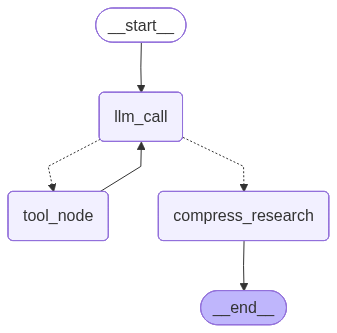

In [26]:
from IPython.display import Image, display

# Show the agent
display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

# Supervisor Agent

In [ ]:
"""
State Definitions for Multi-Agent Research Supervisor

This module defines the state objects and tools used for the multi-agent
research supervisor workflow, including coordination state and research tools.
"""

import operator
from typing_extensions import Annotated, TypedDict, Sequence

from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

class SupervisorState(TypedDict):
    """
    State for the multi-agent research supervisor.
    
    Manages coordination between supervisor and research agents, tracking
    research progress and accumulating findings from multiple sub-agents.
    """

    # Messages exchanged with supervisor
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Detailed research brief generated from the conversation with users
    research_brief: str
    # Processed and structured notes from `raw_notes` ready for final report generation.
    # @qn where will this be used though?
    notes: Annotated[list[str], operator.add] = []
    # Track number of research iterations performed
    research_iterations: int = 0
    # Unprocessed research notes from sub-agent research
    raw_notes: Annotated[list[str], operator.add] = []

# @qn why is this a tool?
# @ans apparantly this is a valid tool syntax: https://blog.langchain.com/tool-calling-with-langchain/. 
#      for python, the pydantic model can be used directly to defined a tool
@tool
class ConductResearch(BaseModel):
    """Tool for delegating a research task to a specialized sub-agent."""
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

@tool
class ResearchComplete(BaseModel):
    """Tool for indicating that the research process is complete."""
    pass

In [28]:
"""Multi-agent supervisor for coordinating research across multiple specialized agents.

This module implements a supervisor pattern where:
1. A supervisor agent coordinates research activities and delegates tasks
2. Multiple researcher agents work on specific sub-topics independently
3. Results are aggregated and compressed for final reporting

The supervisor uses parallel research execution to improve efficiency while
maintaining isolated context windows for each research topic.
"""

import asyncio
from datetime import datetime

from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    HumanMessage, 
    BaseMessage, 
    SystemMessage, 
    ToolMessage,
    filter_messages
)
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

def get_notes_from_tool_calls(messages: list[BaseMessage]) -> list[str]:
    """Extract research notes from ToolMessage objects in supervisor message history.
    
    This function retrieves the compressed research findings that sub-agents
    return as ToolMessage content. When the supervisor delegates research to
    sub-agents via ConductResearch tool calls, each sub-agent returns its
    compressed findings as the content of a ToolMessage. This function
    extracts all such ToolMessage content to compile the final research notes.
    
    Args:
        messages: List of messages from supervisor's conversation history
        
    Returns:
        List of research note strings extracted from ToolMessage objects
    """
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")


# Maximum number of tool call iterations for individual researcher agents
# This prevents infinite loops and controls research depth per topic
max_researcher_iterations = 6 # Calls to think_tool + ConductResearch

# Maximum number of concurrent research agents the supervisor can launch
# This is passed to the lead_researcher_prompt to limit parallel research tasks
max_concurrent_researchers = 3

async def supervisor_node(state: SupervisorState) -> Command[Literal['supervisor_subagents']]:
    """Coordinate research activities.
    
    Analyzes the research brief and current progress to decide:
    - What research topics need investigation
    - Whether to conduct parallel research
    - When research is complete
    
    Args:
        state: Current supervisor state with messages and research progress
        
    Returns:
        Command to proceed to supervisor_subagents node with updated state
    """

    LEAD_RESEARCHER_PROMPT = """You are a research supervisor. Your job is to conduct research by calling the "ConductResearch" tool. For context, today's date is {date}.
    
    <Task>
    Your focus is to call the "ConductResearch" tool to conduct research against the overall research question passed in by the user. 
    When you are completely satisfied with the research findings returned from the tool calls, then you should call the "ResearchComplete" tool to indicate that you are done with your research.
    </Task>
    
    <Available Tools>
    You have access to three main tools:
    1. **ConductResearch**: Delegate research tasks to specialized sub-agents
    2. **ResearchComplete**: Indicate that research is complete
    3. **think_tool**: For reflection and strategic planning during research
    
    **CRITICAL: Use think_tool before calling ConductResearch to plan your approach, and after each ConductResearch to assess progress**
    **PARALLEL RESEARCH**: When you identify multiple independent sub-topics that can be explored simultaneously, make multiple ConductResearch tool calls in a single response to enable parallel research execution. This is more efficient than sequential research for comparative or multi-faceted questions. Use at most {max_concurrent_research_units} parallel agents per iteration.
    </Available Tools>
    
    <Instructions>
    Think like a research manager with limited time and resources. Follow these steps:
    
    1. **Read the question carefully** - What specific information does the user need?
    2. **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the research. Are there multiple independent directions that can be explored simultaneously?
    3. **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still missing?
    </Instructions>
    
    <Hard Limits>
    **Task Delegation Budgets** (Prevent excessive delegation):
    - **Bias towards single agent** - Use single agent for simplicity unless the user request has clear opportunity for parallelization
    - **Stop when you can answer confidently** - Don't keep delegating research for perfection
    - **Limit tool calls** - Always stop after {max_researcher_iterations} tool calls to think_tool and ConductResearch if you cannot find the right sources
    </Hard Limits>
    
    <Show Your Thinking>
    Before you call ConductResearch tool call, use think_tool to plan your approach:
    - Can the task be broken down into smaller sub-tasks?
    
    After each ConductResearch tool call, use think_tool to analyze the results:
    - What key information did I find?
    - What's missing?
    - Do I have enough to answer the question comprehensively?
    - Should I delegate more research or call ResearchComplete?
    </Show Your Thinking>
    
    <Scaling Rules>
    **Simple fact-finding, lists, and rankings** can use a single sub-agent:
    - *Example*: List the top 10 coffee shops in San Francisco → Use 1 sub-agent
    
    **Comparisons presented in the user request** can use a sub-agent for each element of the comparison:
    - *Example*: Compare OpenAI vs. Anthropic vs. DeepMind approaches to AI safety → Use 3 sub-agents
    - Delegate clear, distinct, non-overlapping subtopics
    
    **Important Reminders:**
    - Each ConductResearch call spawns a dedicated research agent for that specific topic
    - A separate agent will write the final report - you just need to gather information
    - When calling ConductResearch, provide complete standalone instructions - sub-agents can't see other agents' work
    - Do NOT use acronyms or abbreviations in your research questions, be very clear and specific
    </Scaling Rules>"""


    supervisor_messages = state.get('supervisor_messages', [])
    system_message = [SystemMessage(content=LEAD_RESEARCHER_PROMPT.format(
        date=get_today_str(),
        max_concurrent_research_units=max_concurrent_researchers,
        max_researcher_iterations=max_researcher_iterations
    ))]
    
    supervisor_tools = [ConductResearch, ResearchComplete, think_tool]
    supervisor_model = init_chat_model(model="openai:gpt-4.1")
    # Just providing the supervisor and subagents with available tools, its up to the subagents to call the tool
    supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

    messages = system_message + supervisor_messages
    response = await supervisor_model_with_tools.ainvoke(messages)
    
    return Command(
        goto="supervisor_subagents",
        update={
            "supervisor_messages": [response],
            # Everytime it comes back to the supervisor, + 1 to the research_iteration
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )

async def supervisor_subagents_node(state: SupervisorState) -> Command[Literal["supervisor", "__end__"]]:
    """Execute supervisor decisions - either conduct research or end the process.
    
    Handles:
    - Executing think_tool calls for strategic reflection
    - Launching parallel research agents for different topics
    - Aggregating research results
    - Determining when research is complete
    
    Args:
        state: Current supervisor state with messages and iteration count
        
    Returns:
        Command to continue supervision, end process, or handle errors
    """

    supervisor_messages = state.get('supervisor_messages', [])
    research_iterations = state.get('research_iterations', 0)
    most_recent_message = supervisor_messages[-1]
    
    tool_messages = []
    all_raw_notes = []
    next_step = "supervisor"
    should_end = False

    # Check exit criteria
    has_exceeded_iterations = research_iterations >= max_researcher_iterations
    has_no_tool_calls = not most_recent_message.tool_calls
    has_research_complete = any(
        tool_call['name'] == 'ResearchComplete'
        for tool_call in most_recent_message.tool_calls
    )
    
    if has_exceeded_iterations or has_no_tool_calls or has_research_complete:
        should_end = True
        next_step = END
    else:
        try:
            think_tool_calls = [
                tool_call for tool_call in most_recent_message.tool_calls
                if tool_call['name'] == 'think_tool'
            ]

            conduct_research_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "ConductResearch"
            ]

            # Reflect on the plan before searching
            for tool_call in think_tool_calls:
                observation = think_tool.invoke(tool_call['args'])
                tool_messages.append(
                    ToolMessage(
                        content=observation,
                        name=tool_call['name'],
                        tool_call_id=tool_call['id']
                    )
                )
            
            # If there are calls for conducting research, DO IT
            if conduct_research_calls:
                research_coroutines = [
                    researcher_agent.ainvoke({
                        "researcher_messages": [
                            HumanMessage(content=tool_call["args"]["research_topic"])
                        ],
                        "research_topic": tool_call["args"]["research_topic"]
                    })
                    for tool_call in conduct_research_calls
                ]

                research_results = await asyncio.gather(*research_coroutines)

                # Format research results as tool messages
                # Each sub-agent returns compressed research findings in result["compressed_research"]
                # We write this compressed research as the content of a ToolMessage, which allows
                # the supervisor to later retrieve these findings via get_notes_from_tool_calls()
                research_tool_messages = [
                    ToolMessage(
                        content=result.get("compressed_research", "Error synthesizing research report"),
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    ) for result, tool_call in zip(research_results, conduct_research_calls)
                ]
                
                tool_messages.extend(research_tool_messages)

                # Aggregate raw notes from all research
                all_raw_notes = [
                    "\n".join(result.get("raw_notes", [])) 
                    for result in research_results
                ]
                
                
                
        except Exception as e:
            print(f"Error in supervisor tools: {e}")
            should_end = True
            next_step = END

    if should_end:
        # EXIT
        return Command(
            goto=next_step,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    else:
        # CONTINUE BITCH
        return Command(
            goto=next_step,
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": all_raw_notes
            }
        )

supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node('supervisor', supervisor_node)
supervisor_builder.add_node('supervisor_subagents', supervisor_subagents_node)
supervisor_builder.add_edge(START, "supervisor")
supervisor_agent = supervisor_builder.compile()


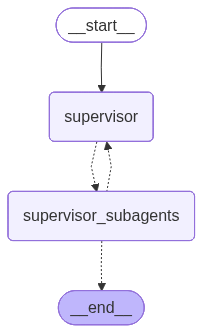

In [29]:
from IPython.display import Image, display

# Show the agent
display(Image(supervisor_agent.get_graph(xray=True).draw_mermaid_png()))

In [30]:
# Run the multi-agent supervisor agent
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await supervisor_agent.ainvoke({"supervisor_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['supervisor_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research goal is to identify and evaluate the best coffee shops in San Francisco based     │
│ specifically on coffee quality, relying on primary sources (official shop websites, reputable coffee review     │
│ organizations, and major review aggregators such as Google and Yelp). Methods of coffee quality assessment can  │
│ include expert reviews, certifications, and direct customer feedback. This is a straightforward fact-finding    │
│ and ranking task focused on a specific geographic location and a single quality dimension. According to         │
│ guidance, a single research agent can likely collect sufficient up-to-date information and compile a ranked     │
│ list or evaluation, as comparison is based on a single main criterion (coffee quality). The instruction is to   │
│ gather the latest data as of July 2025. Next, I will delegate a single research agent to conduct a              │
│ comprehensive survey and evaluation as described."                                                              │
│ }                                                                                                               │
│    ID: call_iu20PO79FAWDiOFLxoav3vIX                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research goal is to identify and evaluate the best coffee shops in San Francisco based │
│ specifically on coffee quality, relying on primary sources (official shop websites, reputable coffee review     │
│ organizations, and major review aggregators such as Google and Yelp). Methods of coffee quality assessment can  │
│ include expert reviews, certifications, and direct customer feedback. This is a straightforward fact-finding    │
│ and ranking task focused on a specific geographic location and a single quality dimension. According to         │
│ guidance, a single research agent can likely collect sufficient up-to-date information and compile a ranked     │
│ list or evaluation, as comparison is based on a single main criterion (coffee quality). The instruction is to   │
│ gather the latest data as of July 2025. Next, I will delegate a single research agent to conduct a              │
│ comprehensive survey and evaluation as described.                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Identify and evaluate the best coffee shops in San Francisco based on coffee quality,      │
│ using the latest available data as of July 2025. Use primary sources including official coffee shop websites,   │
│ reputable third-party coffee review organizations such as Coffee Review and the Specialty Coffee Association,   │
│ and major review aggregators like Google and Yelp that provide direct customer feedback specifically about      │
│ coffee quality. Assess coffee quality through expert reviews, ratings, specialty coffee certifications, and     │
│ customer ratings/comments. Compile a well-supported list or ranking emphasizing coffee quality as the primary   │
│ criterion, explaining sources and methods used for the evaluation."                                             │
│ }                                                                                                               │
│    ID: call_DIxQ4KnHZvhEDuTRF0T1Ren3                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ 1. Query: best coffee shops in San Francisco 2025 coffee quality reviews Coffee Review Specialty Coffee         │
│ Association Google Yelp                                                                                         │
│    Result: Recent Yelp lists of best coffee shops in San Francisco; top coffee shops named include Q Specialty  │
│ Coffee, The Coffee Movement, Progeny Coffee, Black Bird Bookstore and Cafe, among others.                       │
│    Sources: [1], [2], [3]                                                                                       │
│                                                                                                                 │
│ 2. Query: Q Specialty Coffee official website coffee quality expert reviews Specialty Coffee Association        │
│ certifications                                                                                                  │
│    Result: Yelp reviews describe Q Specialty Coffee as offering not just coffee but “an experience, a ritual,   │
│ and a connection” with a focus on fresh, flavorful coffee.                                                      │
│    Sources: [4]                                                                                                 │
│                                                                                                                 │
│ 3. Query: The Specialty Coffee Association is Taking Over the Q Grader Program                                  │
│    Result: The Specialty Coffee Association (SCA) announced it would take over the Q Grader program starting    │
│ October 1, 2025. The Q Grader program is a respected certification for coffee professionals, having certified   │
│ over 8,000 individuals in arabica and robusta coffee quality and post-harvest processes. The transition aims to │
│ evolve the Q program based on SCA's Coffee Value Assessment (CVA) protocols introduced in 2023, which modernize │
│ coffee cupping and evaluation practices. SCA CEO Yannis Apostolopoulos emphasized that the evolved Q Grader     │
│ license will set new industry standards and address community concerns about the previous administration's      │
│ effectiveness. CQI CEO Michael Sheridan highlighted pride in CQI's role over 20 years and excitement for the    │
│ program's future under SCA collaboration. This move reflects efforts to enhance coffee quality standards        │
│ globally and support coffee producers and cuppers through improved evaluation methods.                          │
│                                                                                                                 │
│    Key Excerpts:                                                                                                │
│    "Coffee is more than a score. The partnership between SCA and CQI to evolve the Q Grader program is the      │
│ latest milestone towards delivering on the SCA’s purpose to make coffee better," said Yannis Apostolopoulos,    │
│ CEO of the Specialty Coffee Association.                                                                        │
│    "Upon completion of the program, Q Graders holding the evolved, CVA-based license will set the standard for  │
│ modern coffee evaluation. Through a system that takes a holistic view of value in coffee, they’ll play a key    │
│ role in driving progress in the global specialty coffee industry."                                              │
│    "We are proud of the role we have played in the first 20 years of the Q, and honored by the way it has been  │
│ embraced in the coffee industry… And we are excited to 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research has produced a comprehensive set of findings. Primary sources (official shop      │
│ websites, reputable review organizations, recent Yelp reviews, and Coffee Review ratings) were analyzed for the │
│ most current insights regarding coffee quality in San Francisco. Summary includes:\n\n- A well-supported list   │
│ of highly-rated coffee shops (Q Specialty Coffee, The Coffee Movement, Progeny Coffee, etc.), \n- Descriptions  │
│ emphasizing coffee quality and ethos (freshness, specialty approaches, direct sourcing, innovation),\n-         │
│ Detailed coverage of the Specialty Coffee Association\u2019s enhanced Q Grader program and what it signals      │
│ about coffee shop quality,\n- Coffee Review data on specific coffees from SF roasters, with scoring notes on    │
│ flavor, aroma, and other attributes showing the city\u2019s high coffee standards.\n\nGaps: There is limited    │
│ direct certification data for the individual shops (with the SCA program in transition); most quality           │
│ assessment is via aggregators and customer feedback. Nonetheless, I have sufficient reputable, up-to-date data  │
│ to compile a well-supported list/ranking. I am ready to conclude the research."                                 │
│ }                                                                                                               │
│    ID: call_x9bwlfvKuCqXUXUyDNZ0JtOg                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research has produced a comprehensive set of findings. Primary sources (official shop  │
│ websites, reputable review organizations, recent Yelp reviews, and Coffee Review ratings) were analyzed for the │
│ most current insights regarding coffee quality in San Francisco. Summary includes:                              │
│                                                                                                                 │
│ - A well-supported list of highly-rated coffee shops (Q Specialty Coffee, The Coffee Movement, Progeny Coffee,  │
│ etc.),                                                                                                          │
│ - Descriptions emphasizing coffee quality and ethos (freshness, specialty approaches, direct sourcing,          │
│ innovation),                                                                                                    │
│ - Detailed coverage of the Specialty Coffee Association’s enhanced Q Grader program and what it signals about   │
│ coffee shop quality,                                                                                            │
│ - Coffee Review data on specific coffees from SF roasters, with scoring notes on flavor, aroma, and other       │
│ attributes showing the city’s high coffee standards.                                                            │
│                                                                                                                 │
│ Gaps: There is limited direct certification data for the individual shops (with the SCA program in transition); │
│ most quality assessment is via aggregators and customer feedback. Nonetheless, I have sufficient reputable,     │
│ up-to-date data to compile a well-supported list/ranking. I am ready to conclude the research.                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ResearchComplete                                                                                  │
│    Args: {}                                                                                                     │
│    ID: call_ODbuZwkJHN4W876GWaRqmJJW                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯